Attempt to combine map tools from Daniel Brown and Jerome Degallaix

Andreas Freise, 09.06.2023

In [22]:
import finesse
#from finesse.knm import Map
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
from finesse.utilities.maps import (
    overlap_tilt_coefficients,
    read_metropro_file,
    overlap_piston_coefficient,
)

In [2]:
def read_map(filename):
    # read map in hd5 format
    filepath= pathlib.Path(filename)
    if not filepath.exists():
        raise FileNotFoundError(
            f"Could not find {filepath}.\n\n"
        )

    with h5py.File(filepath, "r") as data:
        x = np.array(data["x"])
        y = np.array(data["y"])
        A = np.array(data["A"])
    return x, y, A

In [461]:
def remove_nan(x,y,A, crop=True):
    nan_idx = np.isnan(A.flat)
    from scipy.interpolate import griddata

    # interpolate NaNs away from the inside
    if np.any(nan_idx):
        # If any nans, interpolate them away
        not_nan_idx = ~nan_idx
        points = np.vstack((X.flat[not_nan_idx], Y.flat[not_nan_idx])).T
        values = A.flat[not_nan_idx]
        xi = np.vstack((X.flat[nan_idx], Y.flat[nan_idx])).T
        A.flat[nan_idx] = griddata(points, values, xi, method="linear")
    
    if (crop):
        # Remove all rows/cols that are just NaN
        # should be left with just data in the 160mm
        # radius for the mirror
        idx_x = ~np.all(np.isnan(A), axis=0)
        idx_y = ~np.all(np.isnan(A), axis=1)
        A = A[:, idx_x]
        A = A[idx_y, :]
        x = x[idx_x]
        y = y[idx_y]
    
    return x, y, A

def remove_tilt_piston(A, spot_size_weight):
    yaw, pitch = overlap_tilt_coefficients(x, y, A, weight_spot=spot_size_weight)
    piston = overlap_piston_coefficient(x, y, A, weight_spot=spot_size_weight)
    A -= yaw * X + pitch * Y + piston
    return A

def crop_map(x,y, A, diameter):
    # todo
    idx_x = ~np.all(np.isnan(A), axis=0)
    idx_y = ~np.all(np.isnan(A), axis=1)
    A = A[:, idx_x]
    A = A[idx_y, :]
    x = x[idx_x]
    y = y[idx_y]


In [462]:
def plot_map(x,y,A):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    p1 = ax.pcolormesh(x,y,A,cmap='jet')
    ax.set_aspect('equal')
    ax.set_xlabel('[m]')
    ax.set_ylabel('[m]')
    #plt.suptitle(f'Reproduction of {fname} with Zernike basis up to order {order}')
    fig.tight_layout()
    # color bar
    cb = plt.colorbar(p1)                 
    cb.set_label("[m]")   
    plt.show()



Alternative code for circular Hann window

% Jerome:
% radially symmetric Hann window taken from:
% Quantitative characterization of surface
% topography using spectral analysis
% equation 15

cut_axis = I_in.Grid.Axis(ind_cut);
Hann_rad_sym = zeros(length(cut_axis));

for ii = 1:length(cut_axis)
    for jj = 1:length(cut_axis)
        if (cut_axis(ii)^2 + cut_axis(jj)^2) < (cut_axis(end))^2
            Hann_rad_sym(ii,jj) = 1 + cos( (2*pi*sqrt(cut_axis(ii)^2 + cut_axis(jj)^2)) /(2*cut_axis(end)) );
        end
    end
end

m =  Hann_rad_sym;

P_window =  (sum(abs(m).^2, 'all')/N_point^2); % Power of the window

map2 = map2.*m;
map2 = map2 / sqrt(P_window);

In [515]:
def psd2d(x,y,A):
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    xlength=x[-1]-x[0]
    ylength=y[-1]-y[0]
    xstep = x[1]-x[0]
    ystep = y[1]-y[0]

    A.flat[np.isnan(A.flat)]=0

    # Create 2D window function
    windowx = np.hanning(x.size)
    #windowy = np.hanning(y.size)
    #window2d = np.sqrt(np.outer(windowx,windowy)) 

    # Circular window function via interpolation
    window2 = np.interp(R,x,windowx)
    window2 /= np.sqrt(np.sum(np.square(np.abs(window2)))/window2.size)
    #plot_map(x,y,window2)

    ft = np.fft.fft2(A*window2)*xstep*ystep
    asd2d = np.fft.fftshift(ft)
    psd2d = np.square(np.abs(asd2d))/(xlength*ylength)

    xfreq = np.fft.fftshift(np.fft.fftfreq(x.size, d=xstep))
    yfreq = np.fft.fftshift(np.fft.fftfreq(y.size, d=ystep))

    xfstep = xfreq[1]-xfreq[0]
    yfstep = yfreq[1]-yfreq[0]

    fX, fY = np.meshgrid(xfreq,yfreq)
    fR = np.sqrt(fX**2+fY**2)

    fradius = xfreq[xfreq.size//2:]
    fstep = xfstep

    psd1d = np.zeros(xfreq.size//2)

    for idx, x in np.ndenumerate(fradius):
        ring=np.where((fR > fradius[idx]) & (fR <= fradius[idx]+fstep))
        psd1d[idx]=np.sum(psd2d[ring])/(len(ring)*xstep**2)
    # remove DC term as it should be zero after removing piston
    return fradius[1:], psd1d[1:]


In [516]:
def synthetic_map(x,y,A, f, psd, **kwargs):

    #randomize phase
    M = np.zeros(A.shape)
    row = M[:,0].shape
    for idx in range(M[0,:].size) :
        M[idx,:] = np.pi - 2*np.pi*np.random.random_sample(row)
        M[:,idx] = -M[idx,:]
                    

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    xlength=x[-1]-x[0]
    ylength=y[-1]-y[0]
    xstep = x[1]-x[0]
    ystep = y[1]-y[0]

    ft = np.zeros(A.shape)

    xfreq = np.fft.fftshift(np.fft.fftfreq(x.size, d=xstep))
    yfreq = np.fft.fftshift(np.fft.fftfreq(y.size, d=ystep))
    fX, fY = np.meshgrid(xfreq,yfreq)
    fR = np.sqrt(fX**2+fY**2)

    print(f"fmax {np.max(xfreq)}, fR max {np.max(fR)}")

    psd2d = np.interp(fR,f,psd)

    plot_map(xfreq, yfreq, np.log(psd2d))

    print(f"psd max {np.max(psd2d)}, min {np.min(psd2d)}")


    plot_map(xfreq,yfreq,psd2d)

    asd2d = np.sqrt(psd2d*xlength*ylength/(xstep*ystep))*np.exp(1j*M)
    map = np.real(np.fft.ifft2(np.fft.ifftshift(asd2d)))
    #map = np.real(np.fft.ifftshift(np.fft.ifft2(asd2d)))
    #map=np.fft.ifftshift(map)
    return x, y, map


--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------


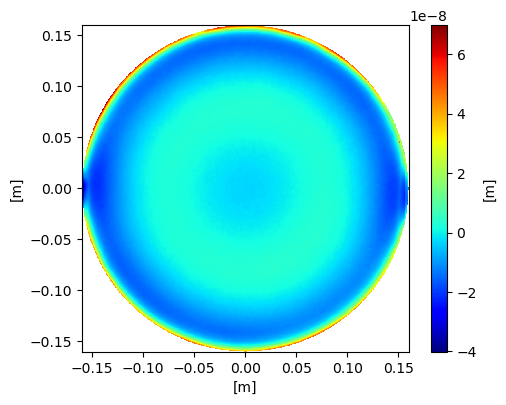

In [517]:
x, y, A = read_map("ETM07.h5");
plot_map(x,y,A)

The results is in the text file [Frequence,PSD value], the PSD is calculated over the 250 mm diameter.

The output of the RMS calculation:

RMS^2 of the cropped surface map: 	 8.48237e-19 
RMS^2 of the cropped windowed surface map: 	 8.67186e-19 
RMS^2 of the 2D PSD: 	 9.81741e-19  
RMS^2 of the integrated radial 1D PSD: 	 4.30902e-19  

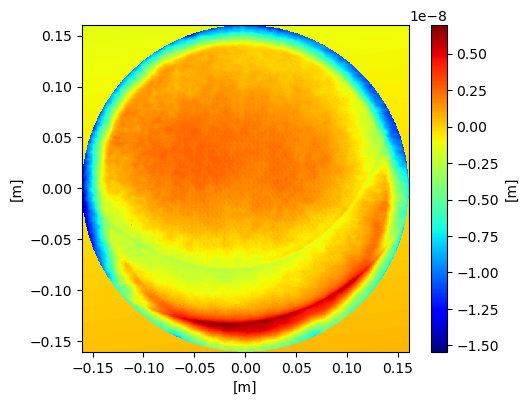

Cutting a part of length 0.25


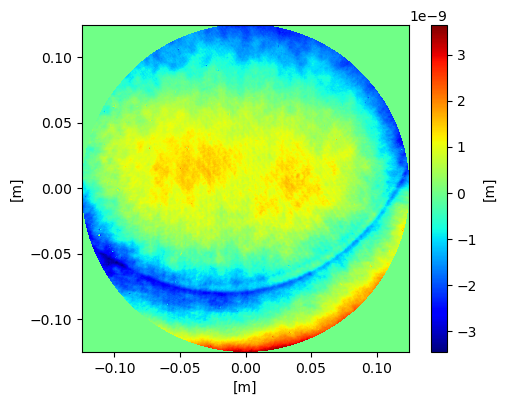

Original map RMS: 1.9768532277617157e-17
Cut map RMS: 1.2976285220776692e-18


In [524]:
data = np.loadtxt("PSD_CP04.txt")
f_org=data[:,0]
psd_org=data[:,1]

A, data = read_metropro_file("CP04_TWF_avge6_final_320mm.dat")

Nx = data["Nx"]
Ny = data["Ny"]

x_extent = data["cameraRes"] * Nx
y_extent = data["cameraRes"] * Ny

x = np.linspace(-x_extent / 2, x_extent / 2, Nx)
y = np.linspace(-y_extent / 2, y_extent / 2, Ny)
X, Y = np.meshgrid(x, y)

A[np.isnan(A)]=0
spot_size_weight=0.15
yaw, pitch = overlap_tilt_coefficients(x, y, A, weight_spot=spot_size_weight)
piston = overlap_piston_coefficient(x, y, A, weight_spot=spot_size_weight)
A -= yaw * X + pitch * Y + piston
    
plot_map(x,y,A)
RMS1 = np.std(np.square(A))

range=0.25
spot_size_weight=0.1
print(f"Cutting a part of length {range}")

xcut = 0.5*(x_extent-range)
ycut = 0.5*(y_extent-range)
#print(f"Cutting {xcut:.2f} in x and {ycut:.2f} in y")
xidx = np.array(np.where((np.abs(x-x[0])>xcut) & (x[-1]-x>xcut))).flatten()
yidx = np.array(np.where((np.abs(y-y[0])>ycut) & (y[-1]-y>ycut))).flatten()
if bool(xidx.size % 2):
    xidx=xidx[:-1]
if bool(yidx.size % 2):
    yidx=yidx[:-1]

x = x[xidx]
y = y[yidx]
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
A=A[xidx[0]:xidx[-1]+1, yidx[0]:yidx[-1]+1]
yaw, pitch = overlap_tilt_coefficients(x, y, A, weight_spot=spot_size_weight)
piston = overlap_piston_coefficient(x, y, A, weight_spot=spot_size_weight)
A -= yaw * X + pitch * Y + piston
A.shape
A[np.where(R>range/2)]=0

plot_map(x,y,A)
RMS = np.std(np.square(A))
print(f"Original map RMS: {RMS1}")
print(f"Cut map RMS: {RMS}")




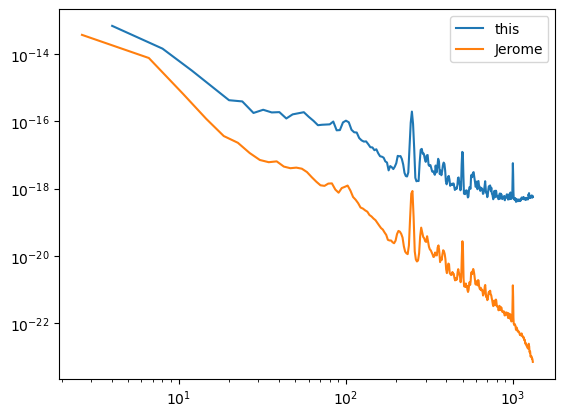

In [525]:
f, psd = psd2d(x,y,A)

plt.loglog(f,psd, label="this")
plt.loglog(f_org,psd_org, label="Jerome")
plt.legend()

In [483]:
data[0,:]

TypeError: unhashable type: 'slice'

fmax 1245.316406249994, fR max 1765.5572442751525


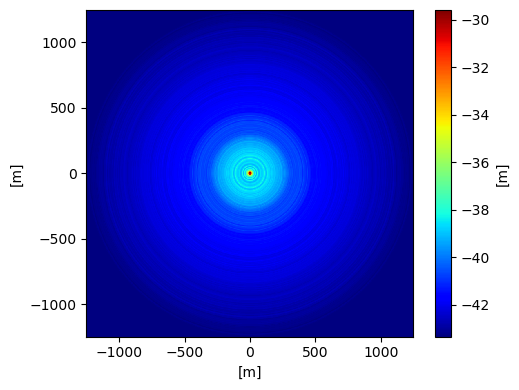

psd max 1.3958612981273188e-13, min 1.5011430848849392e-19


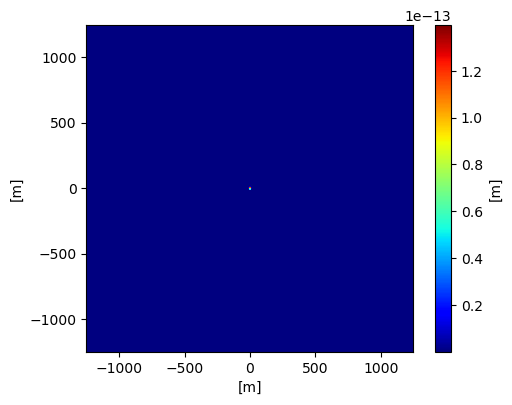

In [325]:
xs, ys, B = synthetic_map(x, y, A, f, psd)

In [339]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

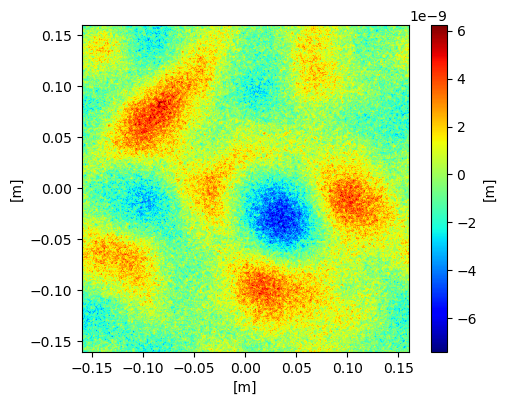

In [329]:
plot_map(x,y,B)

Original map RMS: 3.97436928019057e-18
Maxium size: 0.2262741699796952 m


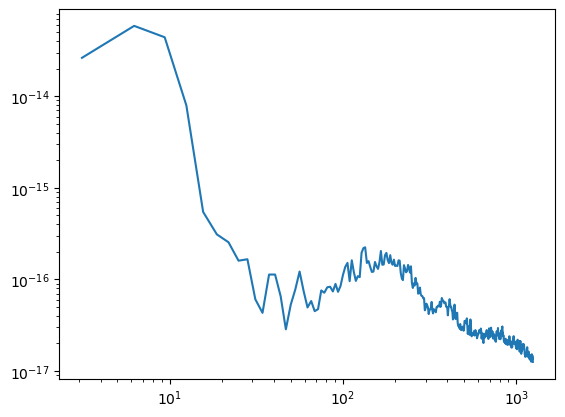

In [327]:
f2,p2 = psd2d(x,y,B)
plt.loglog(f2,p2)

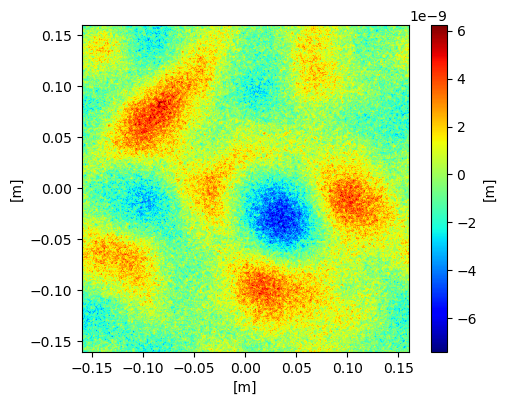

In [328]:
plot_map(x,y,B)

In [306]:
x, y, A = read_map("ETM07.h5");
#plot_map(x,y,A)

f,psd = psd2d(x,y,A)

Original map RMS: 2.248662194956238e-16
Maxium size: 0.2262741699796952 m


In [307]:
psd.shape

(399,)

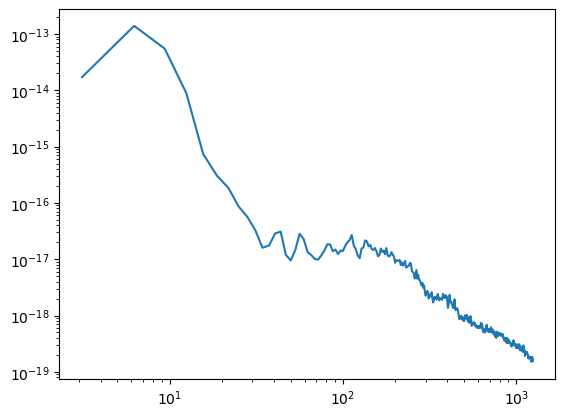

In [299]:
plt.loglog(f,psd)

In [254]:
plot_map(xfreq,yfreq,np.log(np.abs(psd2d)))

TypeError: bad operand type for abs(): 'function'

Random code smippets below here

In [ ]:
from finesse.knm import Map
from finesse.utilities.maps import circular_aperture

....

# create the aperture map
radius = diameter / 2
x = y = np.linspace(-radius, radius, 100)
smap = Map(
            x,
            y,
            amplitude=circular_aperture(x, y, radius, x_offset=0.0, y_offset=0.0),
        )

        # apply to the mirror
model.mirror.surface_map = smap

In [ ]:
from finesse.knm.maps import map_scattering_coefficients

def chrocc_opd(smap, model):
    # chrocc map is in OPD per Watts. Grab the variable 
    # from the model the map is being applied on then
    # scale the OPD output
    P_chrocc = float(model.get("chrocc_W"))
    opd = p_map * P_chrocc
    k = 2*np.pi/1064e-9
    k0000 = np.squeeze(map_scattering_coefficients(model.POPlens.p1.i.q, 0, x, y, np.exp(1j*k*opd)))
    opd += -np.angle(k0000)/k
    return opd.copy()

map_chrocc = finesse.knm.maps.Map(
    x, y,
    opd=chrocc_opd, # use function instead of a fixed array
    amplitude=finesse.utilities.maps.circular_aperture(x, y, 0.175),
    auto_remove_curvatures=True,
    auto_remove_tilts=True,
)